In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
# Read train and test datasets
pd.set_option('display.max_columns', 100)
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Split training set into target variable and explanatory variables
target = np.log(train_df["SalePrice"])
train_df = train_df.drop("SalePrice", axis=1)

train_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0

In [4]:
test_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1459.000000,1459.000000,1455,1232.000000,1459.000000,1459,107,1459,1459,1457,1459,1459,1459,1459,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459.000000,1459,1459,1458,1458,1443,1444.000000,1459,1459,1459,1415,1414,1415,1417,1458.000000,1417,1458.000000,1458.000000,1458.000000,1459,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1458,1459.000000,1457,1459.00000,729,1383,1381.000000,1381,1458.000000,1458.000000,1381,1381,1459,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,3,290,51,1459.000000,1459.000000,1459.000000,1458,1459
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,1,5,3,25,9,5,5,7,NaN,NaN,NaN,NaN,6,4,13,15,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,4,5,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,4,5,3,NaN,NaN,NaN,NaN,NaN,NaN,2,4,3,NaN,NaN,NaN,9,6
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,GLQ,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Ex,MnPrv,Shed,NaN,NaN,NaN,WD,Normal
freq,NaN,NaN,1114,NaN,NaN,1453,70,934,1311,1457,1081,1396,218,1251,1444,1205,745,NaN,NaN,NaN,NaN,1169,1442,510,510,878,NaN,892,1256,661,634,1295,951,431,NaN,1237,NaN,NaN,NaN,1446,752,1358,1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,757,NaN,1357,NaN,364,853,NaN,625,NaN,NaN,1293,1328,1301,NaN,NaN,NaN,NaN,NaN,NaN,2,172,46,NaN,NaN,NaN,1258,1204
mean,2190.000000,57.378341,NaN,68.580357,9819.161069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.078821,5.553804,1971.357779,1983.662783,NaN,NaN,NaN,NaN,NaN,100.709141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.203704,NaN,52.619342,554.294925,1046.117970,NaN,NaN,NaN,NaN,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,NaN,6.385195,NaN,0.58122,NaN,NaN,1977.721217,NaN,1.766118,472.768861,NaN,NaN,NaN,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,NaN,NaN,NaN,58.167923,6.104181,2007.769705,NaN,NaN
std,421.321334,42.746880,NaN,22.376841,4955.517327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436812,1.113740,30.390071,21.130467,NaN,NaN,NaN,NaN,NaN,177.625900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.268042,NaN,176.753926,437.260486,442.898624,NaN,NaN,NaN,NaN,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,NaN,1.508895,NaN,0.64742,NaN,NaN,26.431175,NaN,0.775945,217.048611,NaN,NaN,NaN,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,NaN,NaN,NaN,630.806978,2.722432,1.301740,NaN,NaN
min,1461.000000,20.000000,NaN,21.000000,1470.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1879.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.000000,NaN,0.00000,NaN,NaN,1895.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0

In [5]:
# For numerical features, replace missing values with median, calculated from training set
for feature in ["LotFrontage", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
                "BsmtFullBath", "BsmtHalfBath", "GarageYrBlt", "GarageCars", "GarageArea"]:
    median = train_df[feature].median()
    train_df[feature] = np.where(train_df[feature].isna(), median, train_df[feature])
    test_df[feature] = np.where(test_df[feature].isna(), median, test_df[feature])

In [6]:
# Determine which columns are categorical features
categorical_columns = ["MSSubClass"] # This column is recorded as numeric, but actually represents the type of dwelling
for col in train_df:
    if train_df[col].dtype == "object":
        categorical_columns.append(col)

# For categorical features, replace missing values with "None/Unknown"
for col in categorical_columns:
    train_df[col] = np.where(train_df[col].isna(), "None/Unknown", train_df[col])
    test_df[col] = np.where(test_df[col].isna(), "None/Unknown", test_df[col])
    
train_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460,1460,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,1460,1460,1460.000000,1460,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460,1460
unique,NaN,15,5,NaN,NaN,2,3,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,5,NaN,4,5,6,5,5,5,7,NaN,7,NaN,NaN,NaN,6,5,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,6,7,NaN,4,NaN,NaN,6,6,3,NaN,NaN,NaN,NaN,NaN,NaN,4,5,5,NaN,NaN,NaN,9,6
top,NaN,20,RL,NaN,NaN,Pave,None/Unknown,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,None/Unknown,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,None/Unknown,None/Unknown,None/Unknown,NaN,NaN,NaN,WD,Normal
freq,NaN,536,1151,NaN,NaN,1454,1369,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,690,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,1453,1179,1406,NaN,NaN,NaN,1267,1198
mean,730.500000,NaN,NaN,69.863699,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.117123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.589041,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN
std,421.610009,NaN,NaN,22.027677,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,180.731373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,23.997022,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN
min,1.000000,NaN,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,N

In [7]:
test_df.describe(include="all")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1459.000000,1459,1459,1459.000000,1459.000000,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459.000000,1459,1459,1459,1459,1459,1459.000000,1459,1459,1459,1459,1459,1459,1459,1459.000000,1459,1459.000000,1459.000000,1459.000000,1459,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459,1459.000000,1459,1459.00000,1459,1459,1459.000000,1459,1459.000000,1459.000000,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459,1459,1459,1459.000000,1459.000000,1459.000000,1459,1459
unique,NaN,16,6,NaN,NaN,2,3,4,4,2,5,3,25,9,5,5,7,NaN,NaN,NaN,NaN,6,4,14,16,5,NaN,4,5,6,5,5,5,7,NaN,7,NaN,NaN,NaN,4,5,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,8,NaN,6,7,NaN,4,NaN,NaN,5,6,3,NaN,NaN,NaN,NaN,NaN,NaN,3,5,4,NaN,NaN,NaN,10,6
top,NaN,20,RL,NaN,NaN,Pave,None/Unknown,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,GLQ,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,None/Unknown,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,None/Unknown,None/Unknown,None/Unknown,NaN,NaN,NaN,WD,Normal
freq,NaN,543,1114,NaN,NaN,1453,1352,934,1311,1457,1081,1396,218,1251,1444,1205,745,NaN,NaN,NaN,NaN,1169,1442,510,510,878,NaN,892,1256,661,634,1295,951,431,NaN,1237,NaN,NaN,NaN,1446,752,1358,1337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,757,NaN,1357,NaN,730,853,NaN,625,NaN,NaN,1293,1328,1301,NaN,NaN,NaN,NaN,NaN,NaN,1456,1169,1408,NaN,NaN,NaN,1258,1204
mean,2190.000000,NaN,NaN,68.645648,9819.161069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.078821,5.553804,1971.357779,1983.662783,NaN,NaN,NaN,NaN,NaN,99.673749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,439.165524,NaN,52.583276,554.242289,1046.080535,NaN,NaN,NaN,NaN,1156.534613,325.967786,3.543523,1486.045922,0.433859,0.065113,1.570939,0.377656,2.854010,1.042495,NaN,6.385195,NaN,0.58122,NaN,NaN,1977.843043,NaN,1.766278,472.773818,NaN,NaN,NaN,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,NaN,NaN,NaN,58.167923,6.104181,2007.769705,NaN,NaN
std,421.321334,NaN,NaN,20.561791,4955.517327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436812,1.113740,30.390071,21.130467,NaN,NaN,NaN,NaN,NaN,177.001792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455.114224,NaN,176.698671,437.115132,442.749021,NaN,NaN,NaN,NaN,398.165820,420.610226,44.043251,485.566099,0.530527,0.252307,0.555190,0.503017,0.829788,0.208472,NaN,1.508895,NaN,0.64742,NaN,NaN,25.719563,NaN,0.775703,216.974247,NaN,NaN,NaN,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,NaN,NaN,NaN,630.806978,2.722432,1.301740,NaN,NaN
min,1461.000000,NaN,NaN,21.000000,1470.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1879.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.000000,NaN,0.00000,NaN,NaN,1895.000000,NaN,0.000000,0.000000,NaN,NaN,Na

In [8]:
# Encode categorical features
combined_df = pd.concat((train_df, test_df), axis=0)
dummies = pd.get_dummies(combined_df)
train_categorical = dummies[:len(train_df)]
test_categorical = dummies[len(train_df):]

train_numeric = train_df.drop(categorical_columns, axis=1)
train_df = pd.concat((train_numeric, train_categorical), axis=1)
train_df = train_df.drop(["Id"], axis=1)
train_df = train_df.loc[:,~train_df.columns.duplicated()]
train = np.array(train_df)

test_numeric = test_df.drop(categorical_columns, axis=1)
test_df = pd.concat((test_numeric, test_categorical), axis=1)
test_df = test_df.drop(["Id"], axis=1)
test_df = test_df.loc[:,~test_df.columns.duplicated()]
test = np.array(test_df)

print(train.shape)
print(test.shape)

(1460, 326)
(1459, 326)


In [9]:
# Using the RandomForestRegressor from sklearn
random_forest = RandomForestRegressor(n_estimators=500)
k_fold = KFold(n_splits=5)
error_rates = []

# K-fold cross-validation to estimate the RMSE on unseen data
for train_index, test_index in k_fold.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = target[train_index], target[test_index]
    
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    error_rates.append(rmse)
    print(f"RMSE for this fold: {rmse}")

print(f"Average RMSE: {np.mean(error_rates)}")

RMSE for this fold: 0.1378277156768599
RMSE for this fold: 0.15350248722573456
RMSE for this fold: 0.14498108631687315
RMSE for this fold: 0.1270501039412699
RMSE for this fold: 0.1481342789524173
Average RMSE: 0.14229913442263095


<AxesSubplot:>

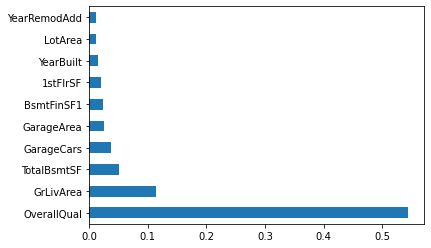

In [10]:
# Plot the most important features
feature_importances = pd.Series(random_forest.feature_importances_, index=train_df.columns)
feature_importances.nlargest(10).plot(kind='barh')

In [11]:
# Make predictions on test set for Kaggle submission
test_pred = np.exp(random_forest.predict(test))
id_col = pd.DataFrame(np.arange(1461, 2920), columns=["Id"])
output = pd.concat((id_col, pd.DataFrame(test_pred, columns=["SalePrice"])), axis=1)
output.to_csv("submission.csv", index=False)
output.head()

,Id,SalePrice
0,1461,126116.292333
1,1462,152764.439623
2,1463,177354.792770
3,1464,179767.084747
4,1465,197343.053450
